# Author: Cem Levent Avcı

### 💾 Drive Connection

Connect Google Drive to Colab and set the working directory to `MyDrive`:

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


### 📂 Directory Preparation and Project Clone

In this section, the folder to be worked on in Google Drive is changed and the necessary project is cloned via GitHub.

These processes prepare the environment to access the project files and start working.

In [6]:
mkdir EfficientAD_Training

In [7]:
cd EfficientAD_Training/

/content/drive/MyDrive/EfficientAD_Training


In [9]:
!git clone https://github.com/nelson1425/EfficientAD.git

Cloning into 'EfficientAD'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 37 (delta 12), reused 9 (delta 9), pack-reused 17 (from 1)
Receiving objects: 100% (37/37), 37.98 MiB | 19.39 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [10]:
ls -al

total 4
drwx------ 5 root root 4096 May 16 10:36 EfficientAD/


In [11]:
cd EfficientAD/

/content/drive/MyDrive/EfficientAD_Training/EfficientAD


## Putting wood_dataset right location

- First, upload given wood_dataset your drive account.
- Second, in Drive, rename wood_dataset as "mvtec_anomaly_detection".
- Third, move the dataset to the correct folder with the following commands.

In [12]:
!mv /content/drive/MyDrive/mvtec_anomaly_detection/ /content/drive/MyDrive/EfficientAD_Training/EfficientAD/

### 📦 Installation and Control of Required Libraries

In this section, the Python libraries needed for the project are installed and the packages installed on the system are checked

In [13]:
pip install tifffile tqdm scikit-learn numpy Pillow scipy tabulate


In [14]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

### 🧠 EfficientAD - MVTec AD (Wood Subset) Training Description

This command trains an anomaly detection model on the wood subset of the MVTec Anomaly Detection dataset.

### 🧠 Model Structure
- **Teacher Model (frozen)**: Pre-trained and used as a reference.

- **Student Model**: Tries to imitate the teacher.

- **Autoencoder**: Works with the outputs of the teacher and the student, learns the differences.


### 📦 Outputs

- **Post-training models**: teacher_final.pth, student_final.pth, autoencoder_final.pth

- Anomaly maps are saved in .tiff format.

- Performance is measured by **ROC AUC value**.

### Overwriting efficientad.py

In [15]:
# %load efficientad.py
%%writefile efficientad.py
#!/usr/bin/python
# -*- coding: utf-8 -*-
import numpy as np
import tifffile
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import argparse
import itertools
import os
import random
from tqdm import tqdm
from common import get_autoencoder, get_pdn_small, get_pdn_medium, \
    ImageFolderWithoutTarget, ImageFolderWithPath, InfiniteDataloader
from sklearn.metrics import roc_auc_score

def get_argparse():
    parser = argparse.ArgumentParser()
    parser.add_argument('-d', '--dataset', default='mvtec_ad',
                        choices=['mvtec_ad', 'mvtec_loco'])
    parser.add_argument('-s', '--subdataset', default='bottle',
                        help='One of 15 sub-datasets of Mvtec AD or 5' +
                             'sub-datasets of Mvtec LOCO')
    parser.add_argument('-o', '--output_dir', default='output/1')
    parser.add_argument('-m', '--model_size', default='small',
                        choices=['small', 'medium'])
    parser.add_argument('-w', '--weights', default='models/teacher_small.pth')
    parser.add_argument('-i', '--imagenet_train_path',
                        default='none',
                        help='Set to "none" to disable ImageNet' +
                             'pretraining penalty. Or see README.md to' +
                             'download ImageNet and set to ImageNet path')
    parser.add_argument('-a', '--mvtec_ad_path',
                        default='./mvtec_anomaly_detection',
                        help='Downloaded Mvtec AD dataset')
    parser.add_argument('-b', '--mvtec_loco_path',
                        default='./mvtec_loco_anomaly_detection',
                        help='Downloaded Mvtec LOCO dataset')
    parser.add_argument('-t', '--train_steps', type=int, default=70000)
    return parser.parse_args()

# constants
seed = 42
on_gpu = torch.cuda.is_available()
out_channels = 384
image_size = 256

# data loading
default_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# transform_ae = transforms.RandomChoice([
#     transforms.ColorJitter(brightness=0.2),
#     transforms.ColorJitter(contrast=0.2),
#     transforms.ColorJitter(saturation=0.2)
# ])

transform_ae = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # az miktarda dikey flip
    transforms.RandomRotation(degrees=10), # hafif rotasyonlar
    transforms.RandomAffine(
        degrees=5,
        translate=(0.02, 0.02),
        scale=(0.95, 1.05),
        shear=3
    ),  # Hafif affine dönüşümler
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Hafif blur
])

def train_transform(image):
    return default_transform(image), default_transform(transform_ae(image))

def main():
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    config = get_argparse()

    if config.dataset == 'mvtec_ad':
        dataset_path = config.mvtec_ad_path
    else:
        raise Exception('Unknown config.dataset')

    pretrain_penalty = True
    if config.imagenet_train_path == 'none':
        pretrain_penalty = False

    # create output dir
    train_output_dir = os.path.join(config.output_dir, 'trainings',
                                    config.dataset, config.subdataset)
    test_output_dir = os.path.join(config.output_dir, 'anomaly_maps',
                                   config.dataset, config.subdataset, 'test')
    os.makedirs(train_output_dir)
    os.makedirs(test_output_dir)

    # load data
    full_train_set = ImageFolderWithoutTarget(
        os.path.join(dataset_path, config.subdataset, 'train'),
        transform=transforms.Lambda(train_transform))
    test_set = ImageFolderWithPath(
        os.path.join(dataset_path, config.subdataset, 'test'))
    if config.dataset == 'mvtec_ad':
        # mvtec dataset paper recommend 10% validation set
        train_size = int(0.9 * len(full_train_set))
        validation_size = len(full_train_set) - train_size
        rng = torch.Generator().manual_seed(seed)
        train_set, validation_set = torch.utils.data.random_split(full_train_set,
                                                           [train_size,
                                                            validation_size],
                                                           rng)
    else:
        raise Exception('Unknown config.dataset')


    train_loader = DataLoader(train_set, batch_size=1, shuffle=True,
                              num_workers=4, pin_memory=True)
    train_loader_infinite = InfiniteDataloader(train_loader)
    validation_loader = DataLoader(validation_set, batch_size=1)

    if pretrain_penalty:
        # load pretraining data for penalty
        penalty_transform = transforms.Compose([
            transforms.Resize((2 * image_size, 2 * image_size)),
            transforms.RandomGrayscale(0.3),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,
                                                                  0.225])
        ])
        penalty_set = ImageFolderWithoutTarget(config.imagenet_train_path,
                                               transform=penalty_transform)
        penalty_loader = DataLoader(penalty_set, batch_size=1, shuffle=True,
                                    num_workers=4, pin_memory=True)
        penalty_loader_infinite = InfiniteDataloader(penalty_loader)
    else:
        penalty_loader_infinite = itertools.repeat(None)

    # create models
    if config.model_size == 'small':
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif config.model_size == 'medium':
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    else:
        raise Exception()
    state_dict = torch.load(config.weights, map_location='cpu')
    teacher.load_state_dict(state_dict)
    autoencoder = get_autoencoder(out_channels)

    # teacher frozen
    teacher.eval()
    student.train()
    autoencoder.train()

    if on_gpu:
        teacher.cuda()
        student.cuda()
        autoencoder.cuda()

    teacher_mean, teacher_std = teacher_normalization(teacher, train_loader)

    optimizer = torch.optim.Adam(itertools.chain(student.parameters(),
                                                 autoencoder.parameters()),
                                 lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=int(0.95 * config.train_steps), gamma=0.1)
    tqdm_obj = tqdm(range(config.train_steps))
    for iteration, (image_st, image_ae), image_penalty in zip(
            tqdm_obj, train_loader_infinite, penalty_loader_infinite):
        if on_gpu:
            image_st = image_st.cuda()
            image_ae = image_ae.cuda()
            if image_penalty is not None:
                image_penalty = image_penalty.cuda()
        with torch.no_grad():
            teacher_output_st = teacher(image_st)
            teacher_output_st = (teacher_output_st - teacher_mean) / teacher_std
        student_output_st = student(image_st)[:, :out_channels]
        distance_st = (teacher_output_st - student_output_st) ** 2
        d_hard = torch.quantile(distance_st, q=0.999)
        loss_hard = torch.mean(distance_st[distance_st >= d_hard])

        if image_penalty is not None:
            student_output_penalty = student(image_penalty)[:, :out_channels]
            loss_penalty = torch.mean(student_output_penalty**2)
            loss_st = loss_hard + loss_penalty
        else:
            loss_st = loss_hard

        ae_output = autoencoder(image_ae)
        with torch.no_grad():
            teacher_output_ae = teacher(image_ae)
            teacher_output_ae = (teacher_output_ae - teacher_mean) / teacher_std
        student_output_ae = student(image_ae)[:, out_channels:]
        distance_ae = (teacher_output_ae - ae_output)**2
        distance_stae = (ae_output - student_output_ae)**2
        loss_ae = torch.mean(distance_ae)
        loss_stae = torch.mean(distance_stae)
        loss_total = loss_st + loss_ae + loss_stae

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        if iteration % 10 == 0:
            tqdm_obj.set_description(
                "Current loss: {:.4f}  ".format(loss_total.item()))

        if iteration % 1000 == 0:
            torch.save(teacher, os.path.join(train_output_dir,
                                             'teacher_tmp.pth'))
            torch.save(student, os.path.join(train_output_dir,
                                             'student_tmp.pth'))
            torch.save(autoencoder, os.path.join(train_output_dir,
                                                 'autoencoder_tmp.pth'))

        if iteration % 10000 == 0 and iteration > 0:
            # run intermediate evaluation
            teacher.eval()
            student.eval()
            autoencoder.eval()

            q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
                validation_loader=validation_loader, teacher=teacher,
                student=student, autoencoder=autoencoder,
                teacher_mean=teacher_mean, teacher_std=teacher_std,
                desc='Intermediate map normalization')
            auc = test(
                test_set=test_set, teacher=teacher, student=student,
                autoencoder=autoencoder, teacher_mean=teacher_mean,
                teacher_std=teacher_std, q_st_start=q_st_start,
                q_st_end=q_st_end, q_ae_start=q_ae_start, q_ae_end=q_ae_end,
                test_output_dir=None, desc='Intermediate inference')
            print('Intermediate image auc: {:.4f}'.format(auc))

            # teacher frozen
            teacher.eval()
            student.train()
            autoencoder.train()

    teacher.eval()
    student.eval()
    autoencoder.eval()

    torch.save(teacher, os.path.join(train_output_dir, 'teacher_final.pth'))
    torch.save(student, os.path.join(train_output_dir, 'student_final.pth'))
    torch.save(autoencoder, os.path.join(train_output_dir,
                                         'autoencoder_final.pth'))

    q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
        validation_loader=validation_loader, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std, desc='Final map normalization')
    auc = test(
        test_set=test_set, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
        q_ae_start=q_ae_start, q_ae_end=q_ae_end,
        test_output_dir=test_output_dir, desc='Final inference')
    print('Final image auc: {:.4f}'.format(auc))

    quantiles = {
        "q_st_start": q_st_start.cpu(),
        "q_st_end": q_st_end.cpu(),
        "q_ae_start": q_ae_start.cpu(),
        "q_ae_end": q_ae_end.cpu()
    }
    torch.save(quantiles, os.path.join(train_output_dir, "map_quantiles.pt"))
    print("Quantile normalizasyon değerleri 'map_quantiles.pt' dosyasına kaydedildi.")

def test(test_set, teacher, student, autoencoder, teacher_mean, teacher_std,
         q_st_start, q_st_end, q_ae_start, q_ae_end, test_output_dir=None,
         desc='Running inference'):
    y_true = []
    y_score = []
    for image, target, path in tqdm(test_set, desc=desc):
        orig_width = image.width
        orig_height = image.height
        image = default_transform(image)
        image = image[None]
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end)
        map_combined = torch.nn.functional.pad(map_combined, (4, 4, 4, 4))
        map_combined = torch.nn.functional.interpolate(
            map_combined, (orig_height, orig_width), mode='bilinear')
        map_combined = map_combined[0, 0].cpu().numpy()

        defect_class = os.path.basename(os.path.dirname(path))
        if test_output_dir is not None:
            img_nm = os.path.split(path)[1].split('.')[0]
            if not os.path.exists(os.path.join(test_output_dir, defect_class)):
                os.makedirs(os.path.join(test_output_dir, defect_class))
            file = os.path.join(test_output_dir, defect_class, img_nm + '.tiff')
            tifffile.imwrite(file, map_combined)

        y_true_image = 0 if defect_class == 'good' else 1
        y_score_image = np.max(map_combined)
        y_true.append(y_true_image)
        y_score.append(y_score_image)
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    return auc * 100

@torch.no_grad()
def predict(image, teacher, student, autoencoder, teacher_mean, teacher_std,
            q_st_start=None, q_st_end=None, q_ae_start=None, q_ae_end=None):

    teacher_output = teacher(image)
    teacher_output = (teacher_output - teacher_mean) / teacher_std
    student_output = student(image)
    autoencoder_output = autoencoder(image)
    map_st = torch.mean((teacher_output - student_output[:, :out_channels])**2,
                        dim=1, keepdim=True)
    map_ae = torch.mean((autoencoder_output -
                         student_output[:, out_channels:])**2,
                        dim=1, keepdim=True)
    if q_st_start is not None:
        map_st = 0.1 * (map_st - q_st_start) / (q_st_end - q_st_start)
    if q_ae_start is not None:
        map_ae = 0.1 * (map_ae - q_ae_start) / (q_ae_end - q_ae_start)
    map_combined = 0.5 * map_st + 0.5 * map_ae
    return map_combined, map_st, map_ae

@torch.no_grad()
def map_normalization(validation_loader, teacher, student, autoencoder,
                      teacher_mean, teacher_std, desc='Map normalization'):
    maps_st = []
    maps_ae = []
    # ignore augmented ae image
    for image, _ in tqdm(validation_loader, desc=desc):
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std)
        maps_st.append(map_st)
        maps_ae.append(map_ae)
    maps_st = torch.cat(maps_st)
    maps_ae = torch.cat(maps_ae)
    q_st_start = torch.quantile(maps_st, q=0.9)
    q_st_end = torch.quantile(maps_st, q=0.995)
    q_ae_start = torch.quantile(maps_ae, q=0.9)
    q_ae_end = torch.quantile(maps_ae, q=0.995)
    return q_st_start, q_st_end, q_ae_start, q_ae_end

@torch.no_grad()
def teacher_normalization(teacher, train_loader):

    mean_outputs = []
    for train_image, _ in tqdm(train_loader, desc='Computing mean of features'):
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        mean_output = torch.mean(teacher_output, dim=[0, 2, 3])
        mean_outputs.append(mean_output)
    channel_mean = torch.mean(torch.stack(mean_outputs), dim=0)
    channel_mean = channel_mean[None, :, None, None]

    mean_distances = []
    for train_image, _ in tqdm(train_loader, desc='Computing std of features'):
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        distance = (teacher_output - channel_mean) ** 2
        mean_distance = torch.mean(distance, dim=[0, 2, 3])
        mean_distances.append(mean_distance)
    channel_var = torch.mean(torch.stack(mean_distances), dim=0)
    channel_var = channel_var[None, :, None, None]
    channel_std = torch.sqrt(channel_var)

    return channel_mean, channel_std

if __name__ == '__main__':
    main()


Overwriting efficientad.py


In [ ]:
#@title If you want to train once more, just run it before training
rm -rf output

## Training EfficientAD

In [16]:
# !python efficientad.py --dataset mvtec_ad --subdataset wood --train_steps 6000
!python efficientad.py --dataset mvtec_ad --subdataset wood --train_steps 3000 --model_size medium --weights models/teacher_medium.pth

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Computing mean of features: 100% 63/63 [00:41<00:00,  1.51it/s]
Computing std of features: 100% 63/63 [00:44<00:00,  1.43it/s]
Current loss: 8.6567  : 100% 3000/3000 [33:20<00:00,  1.50it/s]
Final map normalization: 100% 7/7 [00:10<00:00,  1.47s/it]
Final inference: 100% 141/141 [02:01<00:00,  1.16it/s]
Final image auc: 91.3682
Quantile normalizasyon değerleri 'map_quantiles.pt' dosyasına kaydedildi.


In [17]:
!ls -al

total 80
-rw------- 1 root root  2715 May 16 10:36 benchmark.py
-rw------- 1 root root  4811 May 16 10:36 common.py
-rw------- 1 root root 16223 May 16 10:41 efficientad.py
drwx------ 8 root root  4096 May 16 10:36 .git
-rw------- 1 root root 11357 May 16 10:36 LICENSE
drwx------ 2 root root  4096 May 16 10:36 models
drwx------ 3 root root  4096 Apr 22 15:24 mvtec_anomaly_detection
drwx------ 3 root root  4096 May 16 10:43 output
-rw------- 1 root root 15119 May 16 10:36 pretraining.py
drwx------ 2 root root  4096 May 16 10:43 __pycache__
-rw------- 1 root root  4882 May 16 10:36 README.md
drwx------ 2 root root  4096 May 16 10:36 results


## Testing EfficientAD

### Download mvtec_ad_evaluation

In [20]:
rm -rf mvtec_ad_evaluation

In [21]:
!wget https://www.mydrive.ch/shares/60736/698155e0e6d0467c4ff6203b16a31dc9/download/439517473-1665667812/mvtec_ad_evaluation.tar.xz

--2025-05-16 11:23:24--  https://www.mydrive.ch/shares/60736/698155e0e6d0467c4ff6203b16a31dc9/download/439517473-1665667812/mvtec_ad_evaluation.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11056 (11K) [application/x-xz]
Saving to: ‘mvtec_ad_evaluation.tar.xz’

mvtec_ad_evaluation 100%[===================>]  10.80K  --.-KB/s    in 0.01s   

2025-05-16 11:23:25 (855 KB/s) - ‘mvtec_ad_evaluation.tar.xz’ saved [11056/11056]



In [22]:
!tar -xvf mvtec_ad_evaluation.tar.xz

mvtec_ad_evaluation/
mvtec_ad_evaluation/requirements.txt
mvtec_ad_evaluation/evaluate_experiment.py
mvtec_ad_evaluation/LICENSE.txt
mvtec_ad_evaluation/conda_environment.yml
mvtec_ad_evaluation/evaluate_multiple_experiments.py
mvtec_ad_evaluation/generic_util.py
mvtec_ad_evaluation/README.md
mvtec_ad_evaluation/roc_curve_util.py
mvtec_ad_evaluation/print_metrics.py
mvtec_ad_evaluation/experiment_configs.json
mvtec_ad_evaluation/pro_curve_util.py


In [23]:
!rm mvtec_ad_evaluation.tar.xz

In [24]:
# %load mvtec_ad_evaluation/pro_curve_util.py
%%writefile mvtec_ad_evaluation/pro_curve_util.py
"""Utility function that computes a PRO curve, given pairs of anomaly and ground
truth maps.

The PRO curve can also be integrated up to a constant integration limit.
"""
import numpy as np
from scipy.ndimage.measurements import label


def compute_pro(anomaly_maps, ground_truth_maps):
    """Compute the PRO curve for a set of anomaly maps with corresponding ground
    truth maps.

    Args:
        anomaly_maps: List of anomaly maps (2D numpy arrays) that contain a
          real-valued anomaly score at each pixel.

        ground_truth_maps: List of ground truth maps (2D numpy arrays) that
          contain binary-valued ground truth labels for each pixel.
          0 indicates that a pixel is anomaly-free.
          1 indicates that a pixel contains an anomaly.

    Returns:
        fprs: numpy array of false positive rates.
        pros: numpy array of corresponding PRO values.
    """

    first_shape = anomaly_maps[0].shape
    for i, (a, g) in enumerate(zip(anomaly_maps, ground_truth_maps)):
        if a.shape != first_shape or g.shape != first_shape:
            raise ValueError(f"Shape mismatch at index {i}: anomaly_map shape {a.shape}, ground_truth shape {g.shape}, expected {first_shape}")


    print("Compute PRO curve...")

    # Structuring element for computing connected components.
    structure = np.ones((3, 3), dtype=int)

    num_ok_pixels = 0
    num_gt_regions = 0

    shape = (len(anomaly_maps),
             anomaly_maps[0].shape[0],
             anomaly_maps[0].shape[1])
    fp_changes = np.zeros(shape, dtype=np.uint32)
    assert shape[0] * shape[1] * shape[2] < np.iinfo(fp_changes.dtype).max, \
        'Potential overflow when using np.cumsum(), consider using np.uint64.'

    pro_changes = np.zeros(shape, dtype=np.float64)

    for gt_ind, gt_map in enumerate(ground_truth_maps):

        # Compute the connected components in the ground truth map.
        labeled, n_components = label(gt_map, structure)
        num_gt_regions += n_components

        # Compute the mask that gives us all ok pixels.
        ok_mask = labeled == 0
        num_ok_pixels_in_map = np.sum(ok_mask)
        num_ok_pixels += num_ok_pixels_in_map

        # Compute by how much the FPR changes when each anomaly score is
        # added to the set of positives.
        # fp_change needs to be normalized later when we know the final value
        # of num_ok_pixels -> right now it is only the change in the number of
        # false positives
        fp_change = np.zeros_like(gt_map, dtype=fp_changes.dtype)
        fp_change[ok_mask] = 1

        # Compute by how much the PRO changes when each anomaly score is
        # added to the set of positives.
        # pro_change needs to be normalized later when we know the final value
        # of num_gt_regions.
        pro_change = np.zeros_like(gt_map, dtype=np.float64)
        for k in range(n_components):
            region_mask = labeled == (k + 1)
            region_size = np.sum(region_mask)
            pro_change[region_mask] = 1. / region_size

        fp_changes[gt_ind, :, :] = fp_change
        pro_changes[gt_ind, :, :] = pro_change

    # Flatten the numpy arrays before sorting.
    anomaly_scores_flat = np.array(anomaly_maps).ravel()
    fp_changes_flat = fp_changes.ravel()
    pro_changes_flat = pro_changes.ravel()

    # Sort all anomaly scores.
    print(f"Sort {len(anomaly_scores_flat)} anomaly scores...")
    sort_idxs = np.argsort(anomaly_scores_flat).astype(np.uint32)[::-1]

    # Info: np.take(a, ind, out=a) followed by b=a instead of
    # b=a[ind] showed to be more memory efficient.
    np.take(anomaly_scores_flat, sort_idxs, out=anomaly_scores_flat)
    anomaly_scores_sorted = anomaly_scores_flat
    np.take(fp_changes_flat, sort_idxs, out=fp_changes_flat)
    fp_changes_sorted = fp_changes_flat
    np.take(pro_changes_flat, sort_idxs, out=pro_changes_flat)
    pro_changes_sorted = pro_changes_flat

    del sort_idxs

    # Get the (FPR, PRO) curve values.
    np.cumsum(fp_changes_sorted, out=fp_changes_sorted)
    fp_changes_sorted = fp_changes_sorted.astype(np.float32, copy=False)
    np.divide(fp_changes_sorted, num_ok_pixels, out=fp_changes_sorted)
    fprs = fp_changes_sorted

    np.cumsum(pro_changes_sorted, out=pro_changes_sorted)
    np.divide(pro_changes_sorted, num_gt_regions, out=pro_changes_sorted)
    pros = pro_changes_sorted

    # Merge (FPR, PRO) points that occur together at the same threshold.
    # For those points, only the final (FPR, PRO) point should be kept.
    # That is because that point is the one that takes all changes
    # to the FPR and the PRO at the respective threshold into account.
    # -> keep_mask is True if the subsequent score is different from the
    # score at the respective position.
    # anomaly_scores_sorted = [7, 4, 4, 4, 3, 1, 1]
    # ->          keep_mask = [T, F, F, T, T, F]
    keep_mask = np.append(np.diff(anomaly_scores_sorted) != 0, np.True_)
    del anomaly_scores_sorted

    fprs = fprs[keep_mask]
    pros = pros[keep_mask]
    del keep_mask

    # To mitigate the adding up of numerical errors during the np.cumsum calls,
    # make sure that the curve ends at (1, 1) and does not contain values > 1.
    np.clip(fprs, a_min=None, a_max=1., out=fprs)
    np.clip(pros, a_min=None, a_max=1., out=pros)

    # Make the fprs and pros start at 0 and end at 1.
    zero = np.array([0.])
    one = np.array([1.])

    return np.concatenate((zero, fprs, one)), np.concatenate((zero, pros, one))


def main():
    """
    Compute the area under the PRO curve for a toy dataset and an algorithm
    that randomly assigns anomaly scores to each pixel. The integration
    limit can be specified.
    """

    from generic_util import trapezoid, generate_toy_dataset

    integration_limit = 0.3

    # Generate a toy dataset.
    anomaly_maps, ground_truth_maps = generate_toy_dataset(
        num_images=200, image_width=500, image_height=300, gt_size=10)

    # Compute the PRO curve for this dataset.
    all_fprs, all_pros = compute_pro(
        anomaly_maps=anomaly_maps,
        ground_truth_maps=ground_truth_maps)

    au_pro = trapezoid(all_fprs, all_pros, x_max=integration_limit)
    au_pro /= integration_limit
    print(f"AU-PRO (FPR limit: {integration_limit}): {au_pro}")


if __name__ == "__main__":
    main()


Overwriting mvtec_ad_evaluation/pro_curve_util.py


In [25]:
# %load mvtec_ad_evaluation/evaluate_experiment.py
%%writefile mvtec_ad_evaluation/evaluate_experiment.py
"""Compute evaluation metrics for a single experiment."""

__author__ = "Paul Bergmann, David Sattlegger"
__copyright__ = "2021, MVTec Software GmbH"

import json
from os import listdir, makedirs, path

import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm

import generic_util as util
from pro_curve_util import compute_pro
from roc_curve_util import compute_classification_roc

TARGET_SHAPE = (256, 256)

def parse_user_arguments():
    """Parse user arguments for the evaluation of a method on the MVTec AD
    dataset.

    Returns:
        Parsed user arguments.
    """
    parser = argparse.ArgumentParser(description="""Parse user arguments.""")

    parser.add_argument('--anomaly_maps_dir',
                        required=True,
                        help="""Path to the directory that contains the anomaly
                                maps of the evaluated method.""")

    parser.add_argument('--dataset_base_dir',
                        required=True,
                        help="""Path to the directory that contains the dataset
                                images of the MVTec AD dataset.""")

    parser.add_argument('--output_dir',
                        help="""Path to the directory to store evaluation
                                results. If no output directory is specified,
                                the results are not written to drive.""")

    parser.add_argument('--pro_integration_limit',
                        type=float,
                        default=0.3,
                        help="""Integration limit to compute the area under
                                the PRO curve. Must lie within the interval
                                of (0.0, 1.0].""")

    parser.add_argument('--evaluated_objects',
                        nargs='+',
                        help="""List of objects to be evaluated. By default,
                                all dataset objects will be evaluated.""",
                        choices=util.OBJECT_NAMES,
                        default=util.OBJECT_NAMES)

    args = parser.parse_args()

    # Check that the PRO integration limit is within the valid range.
    assert 0.0 < args.pro_integration_limit <= 1.0

    return args


def parse_dataset_files(object_name, dataset_base_dir, anomaly_maps_dir):
    """Parse the filenames for one object of the MVTec AD dataset.

    Args:
        object_name: Name of the dataset object.
        dataset_base_dir: Base directory of the MVTec AD dataset.
        anomaly_maps_dir: Base directory where anomaly maps are located.
    """
    assert object_name in util.OBJECT_NAMES

    # Store a list of all ground truth filenames.
    gt_filenames = []

    # Store a list of all corresponding anomaly map filenames.
    prediction_filenames = []

    # Test images are located here.
    test_dir = path.join(dataset_base_dir, object_name, 'test')
    gt_base_dir = path.join(dataset_base_dir, object_name, 'ground_truth')
    anomaly_maps_base_dir = path.join(anomaly_maps_dir, object_name, 'test')

    # List all ground truth and corresponding anomaly images.
    for subdir in listdir(str(test_dir)):

        if not subdir.replace('_', '').isalpha():
            continue

        # Get paths to all test images in the dataset for this subdir.
        test_images = [path.splitext(file)[0]
                       for file
                       in listdir(path.join(test_dir, subdir))
                       if path.splitext(file)[1] == '.jpg']

        # If subdir is not 'good', derive corresponding GT names.
        if subdir != 'good':
            gt_filenames.extend(
                [path.join(gt_base_dir, subdir, file + '_mask.jpg')
                 for file in test_images])
        else:
            # No ground truth maps exist for anomaly-free images.
            gt_filenames.extend([None] * len(test_images))

        # Fetch corresponding anomaly maps.
        prediction_filenames.extend(
            [path.join(anomaly_maps_base_dir, subdir, file)
             for file in test_images])

    print(f"Parsed {len(gt_filenames)} ground truth image files.")

    return gt_filenames, prediction_filenames


def calculate_au_pro_au_roc(gt_filenames,
                            prediction_filenames,
                            integration_limit):
    """Compute the area under the PRO curve for a set of ground truth images
    and corresponding anomaly images.

    In addition, the function computes the area under the ROC curve for image
    level classification.

    Args:
        gt_filenames: List of filenames that contain the ground truth images
          for a single dataset object.
        prediction_filenames: List of filenames that contain the corresponding
          anomaly images for each ground truth image.
        integration_limit: Integration limit to use when computing the area
          under the PRO curve.

    Returns:
        au_pro: Area under the PRO curve computed up to the given integration
          limit.
        au_roc: Area under the ROC curve.
        pro_curve: PRO curve values for localization (fpr,pro).
        roc_curve: ROC curve values for image level classifiction (fpr,tpr).
    """
    # Read all ground truth and anomaly images.
    ground_truth = []
    predictions = []

    print("Read ground truth files and corresponding predictions...")
    # for (gt_name, pred_name) in tqdm(zip(gt_filenames, prediction_filenames),
    #                                  total=len(gt_filenames)):
    #     prediction = util.read_tiff(pred_name)
    #     predictions.append(prediction)

    #     if gt_name is not None:
    #         ground_truth.append(np.asarray(Image.open(gt_name)))
    #     else:
    #         ground_truth.append(np.zeros(prediction.shape))

    for (gt_name, pred_name) in tqdm(zip(gt_filenames, prediction_filenames), total=len(gt_filenames)):
      prediction = util.read_tiff(pred_name)
      if prediction.shape != TARGET_SHAPE:
          print(f"[RESIZE] Prediction resized from {prediction.shape} to {TARGET_SHAPE}")
          prediction = np.array(Image.fromarray(prediction).resize((TARGET_SHAPE[1], TARGET_SHAPE[0]), Image.BILINEAR))
      predictions.append(prediction)

      if gt_name is not None:
          gt = np.array(Image.open(gt_name))
          if gt.shape != TARGET_SHAPE:
              print(f"[RESIZE] GT resized from {gt.shape} to {TARGET_SHAPE}")
              gt = np.array(Image.fromarray(gt).resize((TARGET_SHAPE[1], TARGET_SHAPE[0]), Image.NEAREST))
          ground_truth.append(gt)
      else:
          ground_truth.append(np.zeros(TARGET_SHAPE))


    # Compute the PRO curve.
    pro_curve = compute_pro(
        anomaly_maps=predictions,
        ground_truth_maps=ground_truth)

    # Compute the area under the PRO curve.
    au_pro = util.trapezoid(
        pro_curve[0], pro_curve[1], x_max=integration_limit)
    au_pro /= integration_limit
    print(f"AU-PRO (FPR limit: {integration_limit}): {au_pro}")

    # Derive binary labels for each input image:
    # (0 = anomaly free, 1 = anomalous).
    binary_labels = [int(np.any(x > 0)) for x in ground_truth]
    del ground_truth

    # Compute the classification ROC curve.
    roc_curve = compute_classification_roc(
        anomaly_maps=predictions,
        scoring_function=np.max,
        ground_truth_labels=binary_labels)

    # Compute the area under the classification ROC curve.
    au_roc = util.trapezoid(roc_curve[0], roc_curve[1])
    print(f"Image-level classification AU-ROC: {au_roc}")

    # Return the evaluation metrics.
    return au_pro, au_roc, pro_curve, roc_curve


def main():
    """Calculate the performance metrics for a single experiment on the
    MVTec AD dataset.
    """
    # Parse user arguments.
    args = parse_user_arguments()

    # Store evaluation results in this dictionary.
    evaluation_dict = dict()

    # Keep track of the mean performance measures.
    au_pros = []
    au_rocs = []

    # Evaluate each dataset object separately.
    for obj in args.evaluated_objects:
        print(f"=== Evaluate {obj} ===")
        evaluation_dict[obj] = dict()

        # Parse the filenames of all ground truth and corresponding anomaly
        # images for this object.
        gt_filenames, prediction_filenames = \
            parse_dataset_files(
                object_name=obj,
                dataset_base_dir=args.dataset_base_dir,
                anomaly_maps_dir=args.anomaly_maps_dir)

        # Calculate the PRO and ROC curves.
        au_pro, au_roc, pro_curve, roc_curve = \
            calculate_au_pro_au_roc(
                gt_filenames,
                prediction_filenames,
                args.pro_integration_limit)

        evaluation_dict[obj]['au_pro'] = au_pro
        evaluation_dict[obj]['classification_au_roc'] = au_roc

        evaluation_dict[obj]['classification_roc_curve_fpr'] = roc_curve[0]
        evaluation_dict[obj]['classification_roc_curve_tpr'] = roc_curve[1]

        # Keep track of the mean performance measures.
        au_pros.append(au_pro)
        au_rocs.append(au_roc)

        print('\n')

    # Compute the mean of the performance measures.
    evaluation_dict['mean_au_pro'] = np.mean(au_pros).item()
    evaluation_dict['mean_classification_au_roc'] = np.mean(au_rocs).item()

    # If required, write evaluation metrics to drive.
    if args.output_dir is not None:
        makedirs(args.output_dir, exist_ok=True)

        with open(path.join(args.output_dir, 'metrics.json'), 'w') as file:
            json.dump(evaluation_dict, file, indent=4)

        print(f"Wrote metrics to {path.join(args.output_dir, 'metrics.json')}")


if __name__ == "__main__":
    main()


Overwriting mvtec_ad_evaluation/evaluate_experiment.py


In [26]:
!python mvtec_ad_evaluation/evaluate_experiment.py --dataset_base_dir './mvtec_anomaly_detection/' --anomaly_maps_dir './output/1/anomaly_maps/mvtec_ad/' --output_dir './output/1/metrics/mvtec_ad/' --evaluated_objects wood

=== Evaluate wood ===
Parsed 141 ground truth image files.
Read ground truth files and corresponding predictions...
  0% 0/141 [00:00<?, ?it/s][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  1% 1/141 [00:01<03:22,  1.45s/it][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  1% 2/141 [00:03<03:56,  1.70s/it][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  2% 3/141 [00:04<03:00,  1.30s/it][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  3% 4/141 [00:04<02:31,  1.11s/it][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  4% 5/141 [00:05<02:14,  1.01it/s][RESIZE] Prediction resized from (1024, 2800) to (256, 256)
[RESIZE] GT resized from (1024, 2800) to (256, 256)
  4% 6/141

## Some Test Codes

- A portion of the test codes have been integrated with the API.
- Some scripts generate PDF outputs based on user selections or configurations.


### Test Preparation Code

In [27]:
import torch
import os
from common import get_autoencoder, get_pdn_small, get_pdn_medium

# Log fonksiyonu (Hata ayıklama için)
def log_message(message, level="INFO"):
    print(f"[{level}] {message}")

# Model parametreleri
out_channels = 384
model_size = "small"  # Eğer eğitimde "medium" kullandıysan bunu değiştir.

# Model dosyalarının yolları
model_paths = {
    "teacher": "output/1/trainings/mvtec_ad/wood/teacher_final.pth",
    "student": "output/1/trainings/mvtec_ad/wood/student_final.pth",
    "autoencoder": "output/1/trainings/mvtec_ad/wood/autoencoder_final.pth"
}

# Model dosyalarının var olup olmadığını kontrol et
for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        log_message(f"{model_name} modeli bulunamadı: {model_path}", level="ERROR")
        raise FileNotFoundError(f"{model_name} modeli eksik! {model_path} dosyasını kontrol et.")

# GPU Kullanımı (Eğer varsa)
device = "cuda" if torch.cuda.is_available() else "cpu"
log_message(f"Model {device.upper()} cihazında çalışacak.")

# Model yükleme fonksiyonu (Hata yakalama eklenmiş)
def load_model_weights(path, model_name):
    try:
        # PyTorch 2.6'daki güvenlik değişiklikleri için 'weights_only=False' açıkça belirtildi.
        state_dict = torch.load(path, map_location=device, weights_only=False)

        # Eğer model Sequential olarak kaydedilmişse
        if isinstance(state_dict, torch.nn.Sequential):
            log_message(f"{model_name} Sequential modeli olarak doğrudan yüklendi.")
            return state_dict.to(device).eval()

        # Eğer sadece state_dict kaydedilmişse
        elif isinstance(state_dict, dict):
            log_message(f"{model_name} ağırlıkları state_dict olarak yüklendi.")
            return state_dict

        else:
            log_message(f"{model_name} için beklenmeyen dosya formatı: {type(state_dict)}", level="ERROR")
            raise TypeError(f"Geçersiz model formatı: {type(state_dict)}")

    except Exception as e:
        log_message(f"{model_name} model yükleme hatası: {str(e)}", level="ERROR")
        raise e

# Modeli oluştur
try:
    if model_size == "small":
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif model_size == "medium":
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    autoencoder = get_autoencoder(out_channels)
    log_message("Modeller başarıyla oluşturuldu.")
except Exception as e:
    log_message(f"Model oluşturma hatası: {str(e)}", level="ERROR")
    raise e

# Ağırlıkları yükle
teacher_weights = load_model_weights(model_paths["teacher"], "teacher")
student_weights = load_model_weights(model_paths["student"], "student")
autoencoder_weights = load_model_weights(model_paths["autoencoder"], "autoencoder")

# Eğer state_dict() olarak yüklenmişse, modellerin içine yükle
if isinstance(teacher_weights, dict):
    teacher.load_state_dict(teacher_weights)
    teacher.to(device).eval()
if isinstance(student_weights, dict):
    student.load_state_dict(student_weights)
    student.to(device).eval()
if isinstance(autoencoder_weights, dict):
    autoencoder.load_state_dict(autoencoder_weights)
    autoencoder.to(device).eval()

log_message("Tüm modeller başarıyla yüklendi ve test için hazır!")


[INFO] Model CUDA cihazında çalışacak.
[INFO] Modeller başarıyla oluşturuldu.
[INFO] teacher Sequential modeli olarak doğrudan yüklendi.
[INFO] student Sequential modeli olarak doğrudan yüklendi.
[INFO] autoencoder Sequential modeli olarak doğrudan yüklendi.
[INFO] Tüm modeller başarıyla yüklendi ve test için hazır!


## Test 1

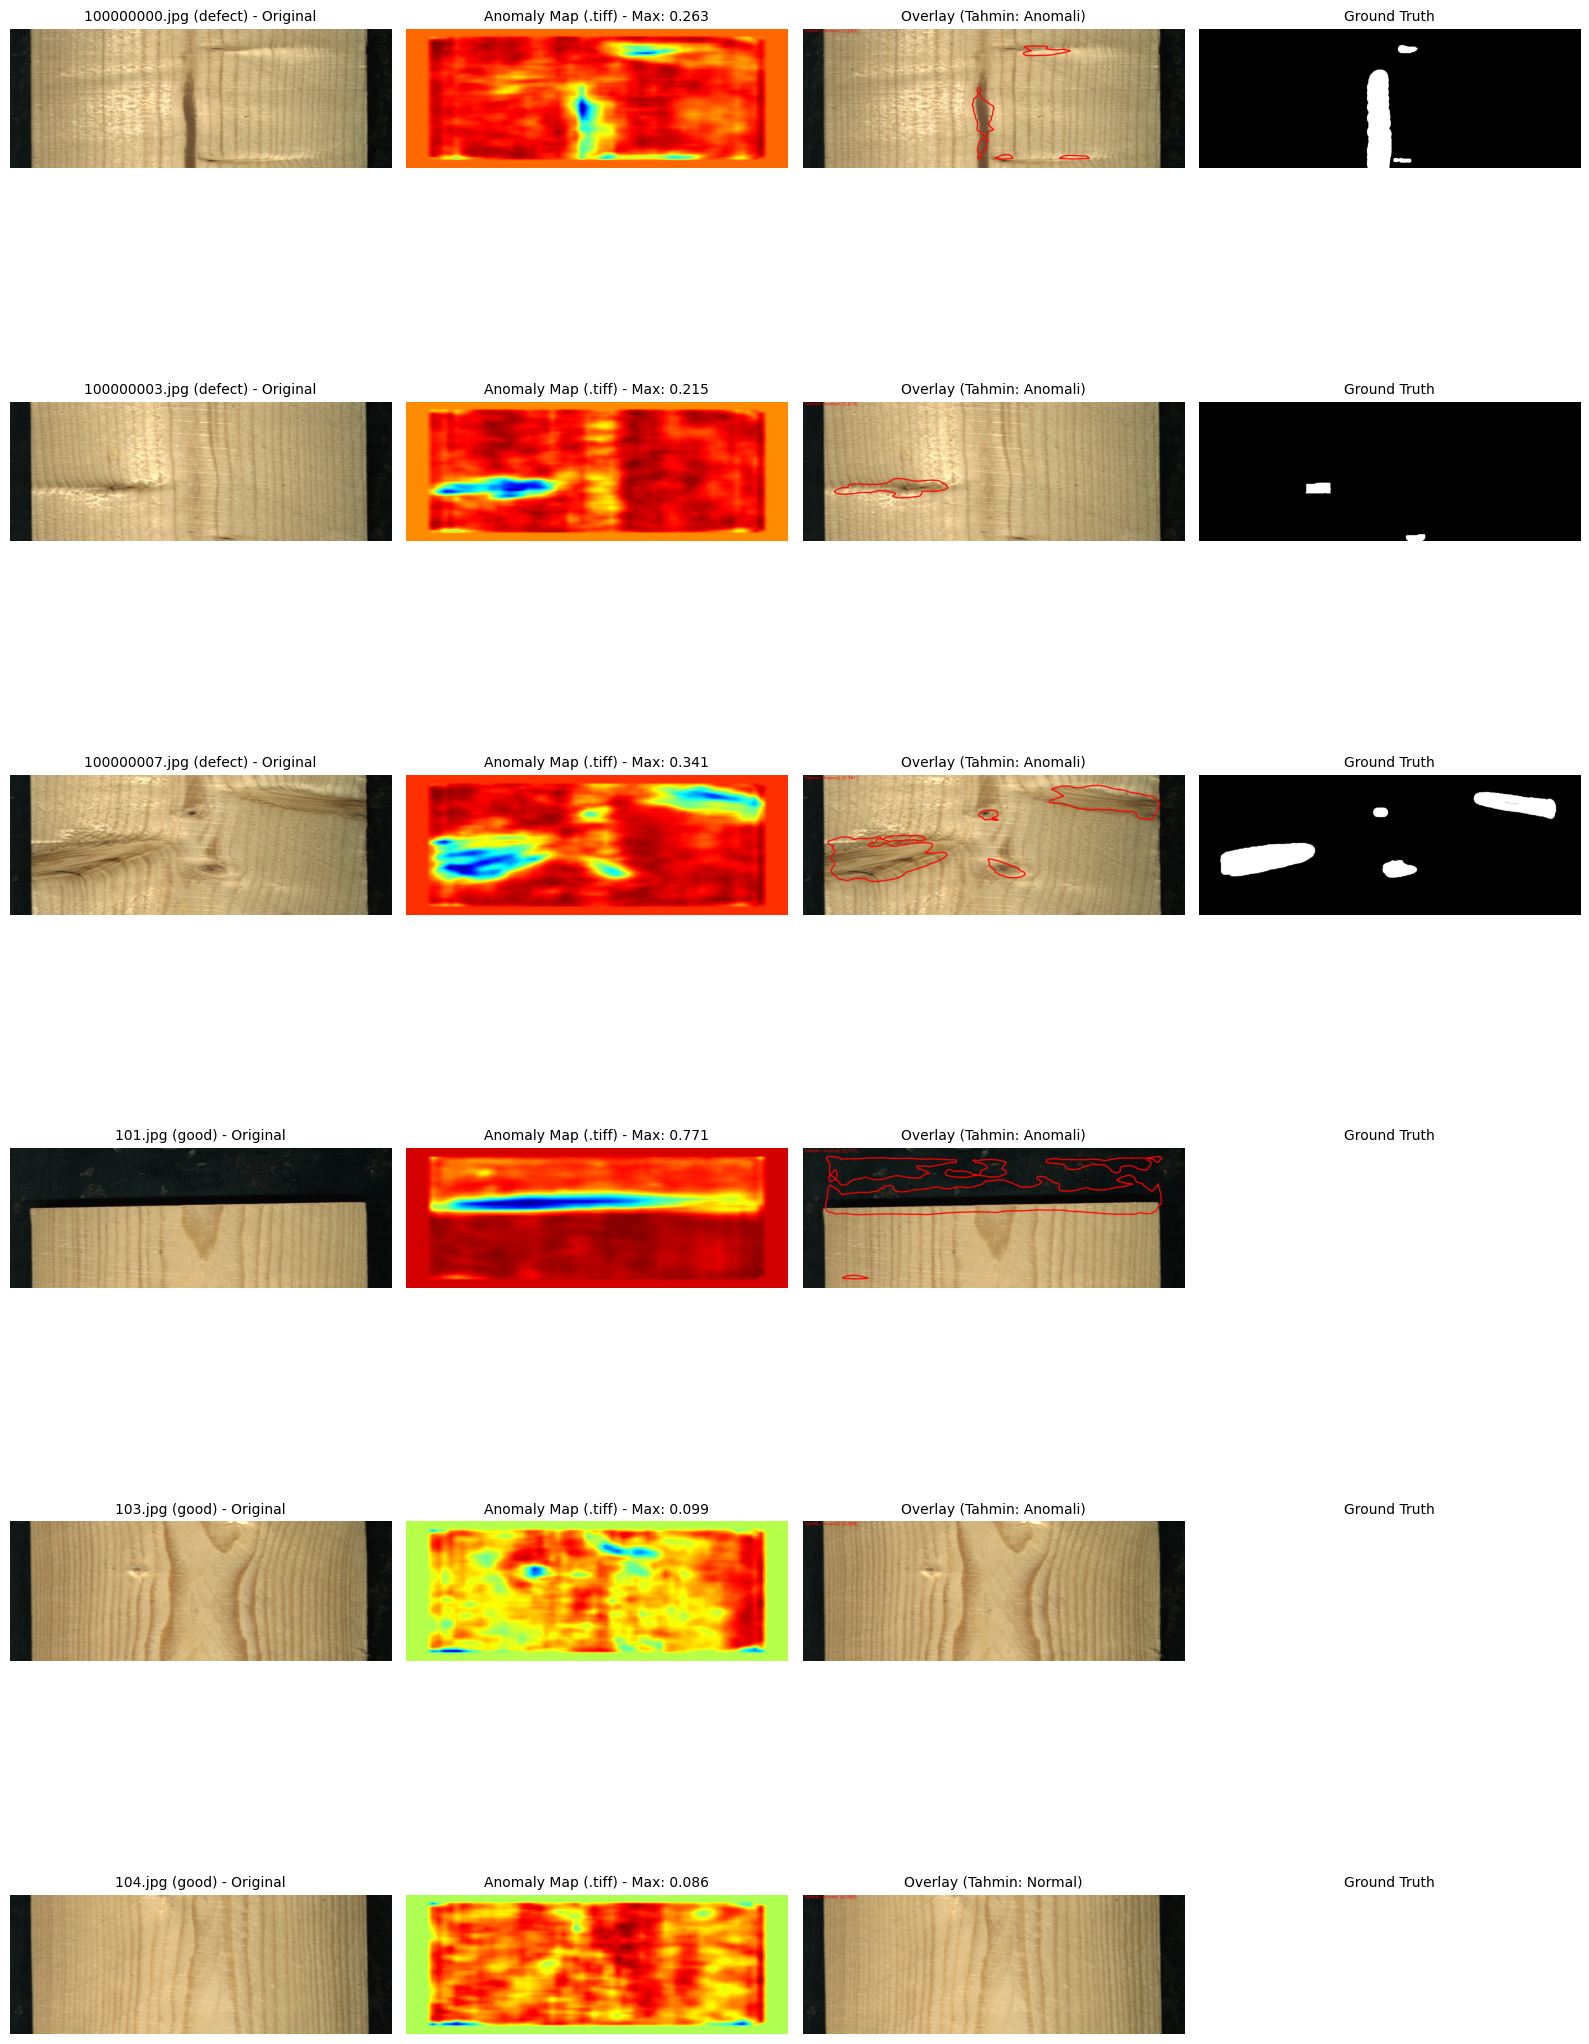

In [29]:
import matplotlib.pyplot as plt
import cv2
import os
import tifffile
import numpy as np

def filter_contours(contours, image_shape, min_area=100, border_margin=30):
    h, w = image_shape[:2]
    filtered = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, cw, ch = cv2.boundingRect(cnt)
        if area > min_area and border_margin < x < w-border_margin and border_margin < y < h-border_margin:
            filtered.append(cnt)
    return filtered

def remove_border_artifacts(anomaly_map, border_px=30):
    h, w = anomaly_map.shape
    mask = np.zeros_like(anomaly_map)
    mask[border_px:h-border_px, border_px:w-border_px] = 1
    return anomaly_map * mask

def show_anomaly_results(image_list,
                         dataset_root='/content/drive/MyDrive/EfficientAD_Training/EfficientAD/mvtec_anomaly_detection/wood/test',
                         gt_root='/content/drive/MyDrive/EfficientAD_Training/EfficientAD/mvtec_anomaly_detection/wood/ground_truth/defect',
                         output_root='/content/drive/MyDrive/EfficientAD_Training/EfficientAD/output/1/anomaly_maps/mvtec_ad/wood/test',
                         contour_threshold=0.6):

    all_images = []
    all_titles = []

    for image_name in image_list:
        image_id = image_name.split('.')[0]

        if os.path.exists(os.path.join(dataset_root, 'defect', image_name)):
            sample_type = 'defect'
        elif os.path.exists(os.path.join(dataset_root, 'good', image_name)):
            sample_type = 'good'
        else:
            print(f"{image_name} bulunamadı, atlanıyor.")
            continue

        # Orijinal Görsel
        orig_path = os.path.join(dataset_root, sample_type, image_name)
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # TIFF Map
        tiff_path = os.path.join(output_root, sample_type, f"{image_id}.tiff")
        if os.path.exists(tiff_path):
            tiff_img = tifffile.imread(tiff_path)

            # Border temizlemeden önce KOPYALA
            tiff_img_masked = remove_border_artifacts(tiff_img.copy(), border_px=40)

            # Skor ve Tahmin
            max_score = np.max(tiff_img_masked)
            prediction = "Anomali" if max_score > contour_threshold else "Normal"

            # Kontur için binary mask
            binary_mask = (tiff_img_masked > contour_threshold).astype(np.uint8) * 255
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = filter_contours(contours, orig_img.shape, min_area=200, border_margin=40)

            # Overlay çizim
            overlay_img = orig_img.copy()
            cv2.drawContours(overlay_img, contours, -1, (255, 0, 0), 7)
            cv2.putText(overlay_img, f"Tahmin: {prediction} ({max_score:.3f})",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Görselleştirme için normalizasyon (tam tiff üzerinden)
            tiff_norm = cv2.normalize(tiff_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            tiff_colored = cv2.applyColorMap(tiff_norm, cv2.COLORMAP_JET)
        else:
            overlay_img = np.ones_like(orig_img) * 255
            tiff_colored = np.ones_like(orig_img) * 255
            max_score = 0
            prediction = "Yok"

        # Ground Truth
        gt_path = os.path.join(gt_root, f"{image_id}_mask.jpg")
        if os.path.exists(gt_path):
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        else:
            gt_img = np.ones_like(orig_img) * 255

        # Görselleri ekle
        all_images.extend([orig_img, tiff_colored, overlay_img, gt_img])
        all_titles.extend([
            f"{image_name} ({sample_type}) - Original",
            f"Anomaly Map (.tiff) - Max: {max_score:.3f}",
            f"Overlay (Tahmin: {prediction})",
            "Ground Truth"
        ])

    # Grid Görselleştirme
    n = len(all_images) // 4
    fig, axs = plt.subplots(n, 4, figsize=(16, 4 * n))
    for i in range(n):
        for j in range(4):
            ax = axs[i][j] if n > 1 else axs[j]
            ax.imshow(all_images[i * 4 + j])
            ax.set_title(all_titles[i * 4 + j], fontsize=10)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


# Örnek Kullanım
show_anomaly_results([
    "100000000.jpg", "100000003.jpg", "100000007.jpg",
    "101.jpg", "103.jpg", "104.jpg"
], contour_threshold=0.09)


## Test 2

[INFO] Model CUDA cihazında çalışacak.
[INFO] Tüm modeller başarıyla yüklendi.
[INFO] 141 test görüntüsü bulundu. Model değerlendiriliyor...
[INFO] Adaptive Threshold (ROC-optimal): 3.5811
[INFO] F1 Score: 0.6525
[INFO] ROC-AUC: 0.6694
[INFO] Precision-Recall AUC: 0.6961
[INFO] Ortalama IoU: 0.0269


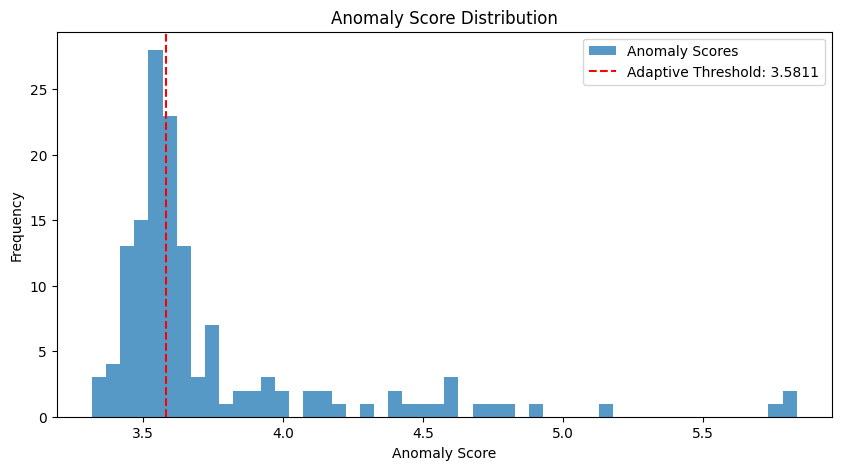

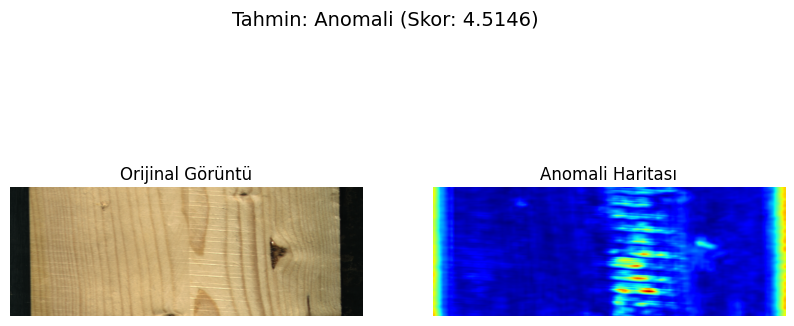

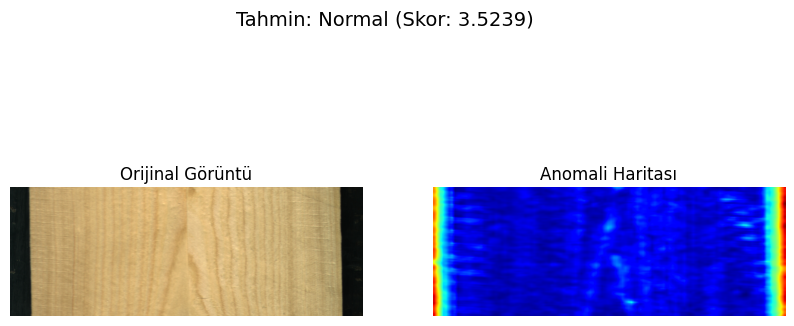

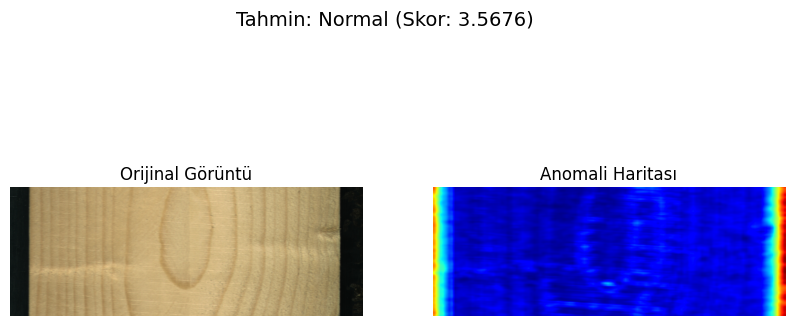

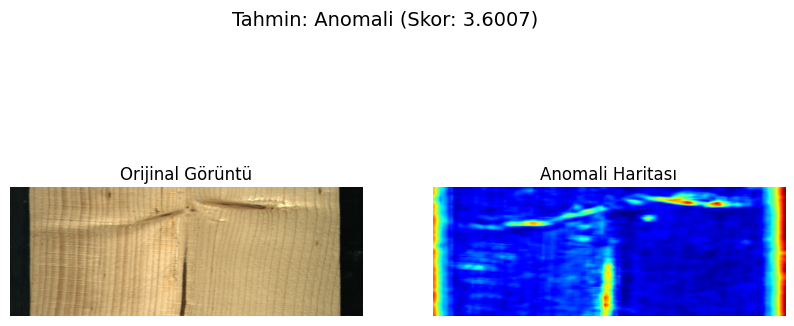

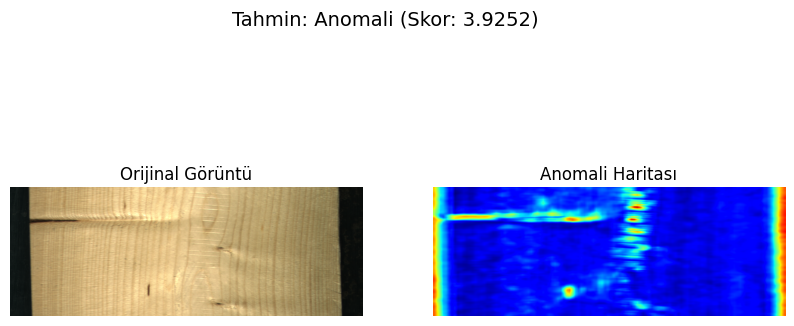

[INFO] Test tamamlandı!


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data import Dataset, DataLoader


# ==================== LOGGING ====================
def log_message(message, level="INFO"):
    print(f"[{level}] {message}")

# ==================== CİHAZ SEÇİMİ ====================
def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_message(f"Model {device.upper()} cihazında çalışacak.")
    return device

# ==================== GÖRÜNTÜ DÖNÜŞÜMÜ ====================
def get_transform():
    return transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# ==================== MODEL YÜKLEME ====================
def load_models(device):
    import torch.serialization
    from torch.nn import Sequential
    torch.serialization.add_safe_globals({'Sequential': Sequential})

    teacher_path = "output/1/trainings/mvtec_ad/wood/teacher_final.pth"
    student_path = "output/1/trainings/mvtec_ad/wood/student_final.pth"
    autoencoder_path = "output/1/trainings/mvtec_ad/wood/autoencoder_final.pth"

    for path in [teacher_path, student_path, autoencoder_path]:
        if not os.path.exists(path):
            log_message(f"Model dosyası eksik: {path}", level="ERROR")
            raise FileNotFoundError(f"Model dosyası bulunamadı: {path}")

    try:
        teacher = torch.load(teacher_path, map_location=device, weights_only=False).to(device).eval()
        student = torch.load(student_path, map_location=device, weights_only=False).to(device).eval()
        autoencoder = torch.load(autoencoder_path, map_location=device, weights_only=False).to(device).eval()
        log_message("Tüm modeller başarıyla yüklendi.")
        return teacher, student, autoencoder
    except Exception as e:
        log_message(f"Modeller yüklenemedi: {str(e)}", level="ERROR")
        raise e

# ==================== TEST VERİSETİ ====================
class TestDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        try:
            image = Image.open(path).convert("RGB")
            image = image.resize((512, 512), Image.BILINEAR)
            return self.transform(image), path
        except Exception as e:
            log_message(f"Görüntü bozuk: {path} - {str(e)}", level="ERROR")
            return None, path  # Bozuksa None dön

    def __len__(self):
        return len(self.image_paths)



# ==================== GÖRÜNTÜ YÜKLE ====================
def load_test_images(path="/content/drive/MyDrive/EfficientAD_Training/EfficientAD/mvtec_anomaly_detection/wood/test/*/*.jpg"):
    image_paths = glob.glob(path)
    if not image_paths:
        log_message("Test görüntüleri bulunamadı! Lütfen test setini kontrol et.", level="ERROR")
        raise FileNotFoundError("Test setinde görüntü bulunamadı!")
    log_message(f"{len(image_paths)} test görüntüsü bulundu. Model değerlendiriliyor...")
    return image_paths

# ==================== TEST ====================
def test_model(image, teacher, student, autoencoder, device, output_size):
    with torch.no_grad():
        image = image.to(device)

        # Siyah arka planı maskele


        teacher_output = teacher(image)
        student_output = student(image)
        _ = autoencoder(image)
        anomaly_map = torch.mean((teacher_output - student_output[:, :384]) ** 2, dim=1, keepdim=True)
        anomaly_map = torch.nn.functional.interpolate(anomaly_map, size=output_size[::-1], mode="bilinear")  # (w,h) -> (h,w)
        return anomaly_map.squeeze().cpu().numpy()


# ==================== IoU HESABI ====================
def calculate_iou(pred_mask, true_mask, threshold=0.3):
    pred_mask = (pred_mask > threshold).astype(np.uint8)
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

# ==================== DEĞERLENDİR ====================
def evaluate_model(loader, teacher, student, autoencoder, device, transform):
    y_true, y_scores, ious = [], [], []
    for images, paths in loader:
        for image, path in zip(images, paths):
            if image is None:
                continue
            try:
                image = image.to(device).unsqueeze(0)
                anomaly_map = test_model(image, teacher, student, autoencoder, device, (512, 512))
                score = np.max(anomaly_map)
                true_label = 0 if "good" in path else 1
                y_true.append(true_label)
                y_scores.append(score)

                if true_label == 1:
                    gt_path = path.replace("test", "ground_truth").replace(".jpg", "_mask.jpg")
                    if os.path.exists(gt_path):
                        gt_mask = Image.open(gt_path).convert("L").resize((512, 512))
                        gt_mask = np.array(gt_mask) > 0
                        iou = calculate_iou(anomaly_map, gt_mask)
                        ious.append(iou)
            except Exception as e:
                log_message(f"Hata: {path} - {str(e)}", level="ERROR")
    return y_true, y_scores, ious





# ==================== METRİKLER ====================
def compute_metrics(y_true, y_scores, ious):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_scores > optimal_threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    iou_mean = np.mean(ious) if ious else None

    return {
        "threshold": optimal_threshold,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "iou_mean": iou_mean
    }



# ==================== SONUÇLARI YAZDIR ====================
def display_results(metrics):
    log_message(f"Adaptive Threshold (ROC-optimal): {metrics['threshold']:.4f}")
    log_message(f"F1 Score: {metrics['f1']:.4f}")
    log_message(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    log_message(f"Precision-Recall AUC: {metrics['pr_auc']:.4f}")
    if metrics['iou_mean'] is not None:
        log_message(f"Ortalama IoU: {metrics['iou_mean']:.4f}")


# ==================== HISTOGRAM ====================
def plot_histogram(y_scores, threshold):
    plt.figure(figsize=(10, 5))
    plt.hist(y_scores, bins=50, alpha=0.75, label="Anomaly Scores")
    plt.axvline(x=threshold, color='red', linestyle="--", label=f"Adaptive Threshold: {threshold:.4f}")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Anomaly Score Distribution")
    plt.legend()
    plt.show()


# ==================== ÖRNEK GÖRSELLER ====================
def visualize_examples(test_paths, transform, teacher, student, autoencoder, device, threshold):
    sample_images = np.random.choice(test_paths, min(5, len(test_paths)), replace=False)
    for img_path in sample_images:
        try:
            image = Image.open(img_path).convert("RGB")
            size = image.size
            image_tensor = transform(image).unsqueeze(0).to(device)
            anomaly_map = test_model(image_tensor, teacher, student, autoencoder, device, size)
            score = np.max(anomaly_map)
            prediction = "Anomali" if score > threshold else "Normal"

            plt.figure(figsize=(10, 5))
            plt.suptitle(f"Tahmin: {prediction} (Skor: {score:.4f})", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Orijinal Görüntü")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(anomaly_map, cmap="jet")
            plt.title("Anomali Haritası")
            plt.axis("off")
            plt.show()
        except Exception as e:
            log_message(f"Görselleştirme hatası: {img_path} - {str(e)}", level="ERROR")



# ==================== ANA FONKSİYON ====================
def main():
    device = get_device()
    teacher, student, autoencoder = load_models(device)
    transform = get_transform()
    test_paths = load_test_images()
    dataset = TestDataset(test_paths, transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    # transform parametresini buraya ekle!
    y_true, y_scores, ious = evaluate_model(loader, teacher, student, autoencoder, device, transform)
    metrics = compute_metrics(y_true, y_scores, ious)

    display_results(metrics)
    plot_histogram(y_scores, metrics["threshold"])
    visualize_examples(test_paths, transform, teacher, student, autoencoder, device, metrics["threshold"])
    log_message("Test tamamlandı!")

# ==================== ÇALIŞTIR ====================
if __name__ == "__main__":
    main()  # kodun çalışması




### Test 3 (.tiff files)

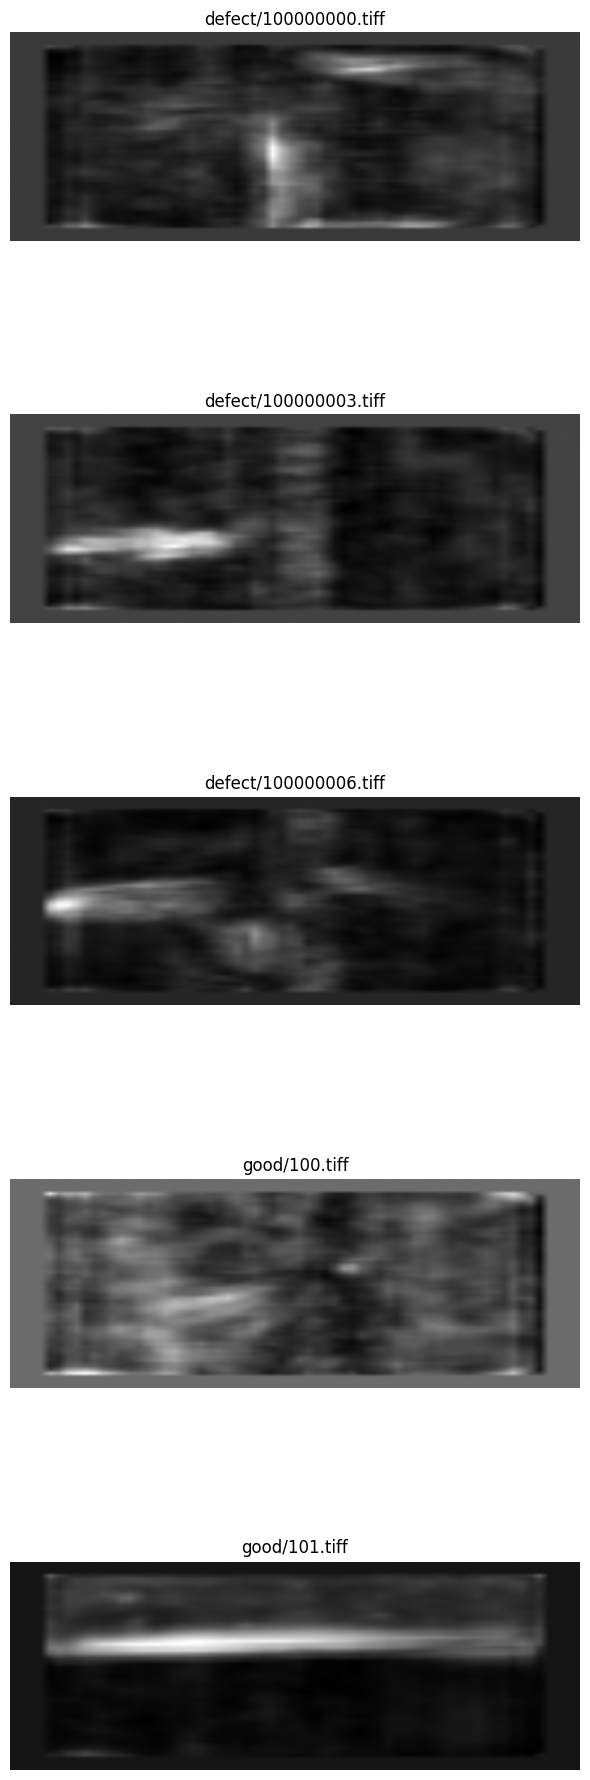

In [38]:
import os
import matplotlib.pyplot as plt
import tifffile as tiff

def show_tiffs(base_dir, tiff_files):
    """
    Verilen TIFF dosya adlarını, 'defect' veya 'good' klasörlerinden bulup gösterir.

    Args:
        base_dir (str): 'test' klasörüne kadar olan yol (örneğin: ".../wood/test")
        tiff_files (list): Sadece .tiff dosya isimleri
    """
    num_files = len(tiff_files)
    fig, axes = plt.subplots(num_files, 1, figsize=(6, 4 * num_files))

    if num_files == 1:
        axes = [axes]

    for ax, file_name in zip(axes, tiff_files):
        found = False
        for subfolder in ['defect', 'good']:
            file_path = os.path.join(base_dir, subfolder, file_name)
            if os.path.isfile(file_path):
                image = tiff.imread(file_path)

                if image.ndim == 2:
                    ax.imshow(image, cmap='gray')
                else:
                    ax.imshow(image)

                ax.set_title(f"{subfolder}/{file_name}")
                ax.axis('off')
                found = True
                break

        if not found:
            print(f"Dosya bulunamadı: {file_name}")

    plt.tight_layout()
    plt.show()


tiff_dosyalari = ["100000000.tiff", "100000003.tiff", "100000006.tiff", "100.tiff", "101.tiff"]
klasor_yolu = "output/1/anomaly_maps/mvtec_ad/wood/test"
show_tiffs(klasor_yolu, tiff_dosyalari)